<a href="https://colab.research.google.com/github/niclasko/Data-Science/blob/main/Cruise_Ship_crew_size_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cruise Ship crew size analysis
Predict cruise ship crew size based on ship characteristics.<br>
<b>Author:</b> Niclas Kjäll-Ohlsson (niclasko@gmail.com)

#### Import libraries

In [ ]:
# Data wrangling
import pandas as pd
import numpy as np

# Modeling
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics.scorer import make_scorer

# Metrics
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Read data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/niclasko/niclasko.github.io/master/data/cruise_ship_info.csv")

categorical = ["Ship_name", "Cruise_line"]
numerical = ["Age", "Tonnage", "passengers", "length", "cabins", "passenger_density", "crew"]
target_variable = "crew"
numerical_independent_variables = [i for i in numerical if i!=target_variable]


data.head(5)

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


Simple statistics over data

In [ ]:
data.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


#### One-hot encode categorical variable Cruise_line
Here we create one column per value of Cruise_line where 0/1 denotes observation not having corresponding Cruise_line value or having. A possible usage of this one-hot encoding is for modeling interaction terms between numerical variables and Cruise_line, e.g. Orient*Tonnage. This to capture numerical variable distribution conditioned on Cruise_line.

In [ ]:
one_hots = pd.get_dummies(data["Cruise_line"])
one_hot_variables = one_hots.columns.values.tolist()

data = data.join(one_hots)

data.head(5)

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew,Azamara,Carnival,Celebrity,Costa,Crystal,Cunard,Disney,Holland_American,MSC,Norwegian,Oceania,Orient,P&O,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star,Windstar
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis

#### Target variable analysis
We can see that the target variable crew size is fairly normally distributed around mode of 9.2, and mean of around 7.7, with a slight skewing towards lower values. We can see two outliers at around 20, which are both well above the 95th percentile (~12.5).

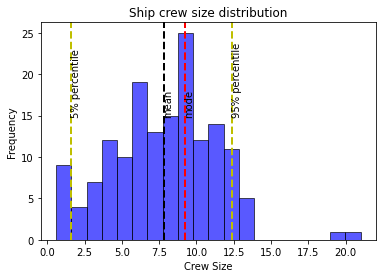

In [ ]:
crew_hist = plt.hist(data.crew, bins=20, color="blue", edgecolor="k", alpha=0.65)
crew_quantiles = data.crew.quantile([.05,.95]).values
plt.axvline(crew_quantiles[0], color="y", linestyle="dashed", linewidth=2)
plt.text(crew_quantiles[0], 15, "5% percentile", rotation=90)
plt.axvline(crew_quantiles[1], color="y", linestyle="dashed", linewidth=2)
plt.text(crew_quantiles[1], 15, "95% percentile", rotation=90)
plt.axvline(data.crew.mode().values[0], color='r', linestyle="dashed", linewidth=2)
plt.text(data.crew.mode().values[0], 15, "mode", rotation=90)
plt.axvline(data.crew.mean(), color="black", linestyle="dashed", linewidth=2)
plt.text(data.crew.mean(), 15, "mean", rotation=90)
plt.xlabel("Crew Size")
plt.ylabel("Frequency")
plt.title("Ship crew size distribution")
plt.show()

#### Independent variable analysis
Looking at the correlation (Pearson) between the different numerical variables (Tonnage, passengers, length, cabins, passenger_density & crew) we can see that there is a strong positive correlation between all variables except for passenger_density. Age shows a medium negative correlation to crew size. All in all we have indication of linearity between variables, except for passenger_density which shows a weaker correlation signal and a negative one. Variables with strong correlation are good predictors in a regression model, hence will likely predict target variable crew size well.

Pearson correlation is defined as:

$\rho_{X,Y} = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}$, where<br>
$cov_{X,Y} = \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})$ and <br>
$\bar{x} = \frac{1}{N} \sum_{i=1}^N x_i$ and <br>
$\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \bar{x})^2}$<br>

How to interpret Pearson correlation (source: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient):<br><br>
<i>The correlation coefficient ranges from −1 to 1. A value of 1 implies that a linear equation describes the relationship between X and Y perfectly, with all data points lying on a line for which Y increases as X increases. A value of −1 implies that all data points lie on a line for which Y decreases as X increases. A value of 0 implies that there is no linear correlation between the variables.</i>

In [ ]:
corr = data[numerical].corr()
corr.style.background_gradient(cmap="BrBG")

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


passenger_density is the variable with the lowest correlation towards target variable crew size, as well as to other variables. Hence, it is the most noisy variable. It could be a candidate for removal in modeling below.

In [ ]:
fig = px.scatter_matrix(data,
    dimensions=numerical,
    color="crew",
    height=800
)
fig.show()

Next looking at the variables with the strongest correlation to target variable crew size, we can see below that cabins, Tonnage, passengers, length have strong positive correlation with crew size. passenger_density has a weak negative correlation with crew size.

In [ ]:
print("Independent variable correlation with target variable crew size")
pd.DataFrame(corr.loc[corr.index.values != "crew", "crew"].sort_values(ascending=False))\
    .rename(columns={"crew": "Crew size correlation"})

Independent variable correlation with target variable crew size


,Crew size correlation
cabins,0.950823
Tonnage,0.927569
passengers,0.915234
length,0.895857
passenger_density,-0.155509
Age,-0.530657


#### Clustering analysis
Next we perform a singular value decomposition matrix factorisation in order to cluster the data in 2 dimensions. We project the numerical variables (without target variable crew) along the two components (variable weightings) that explain most of the variance in the dataset.

Then the SVD projections are clustered using K-means algorithm. We can see in the plot below that data points in latent 2D SVD space are similar also in data space (hover points to see actual data).

In [ ]:
svd = TruncatedSVD(n_components=2, n_iter=200, random_state=42)
svd_projections = svd.fit_transform(
    data[numerical_independent_variables])

data_clustered = data[categorical+numerical].join(
    pd.DataFrame(svd_projections, columns=["svd_X", "svd_Y"]))

data_clustered.loc[:, "cluster"] =\
    KMeans(n_clusters=4, random_state=0).fit(data_clustered[["svd_X", "svd_Y"]]).labels_

We can see that the two SVD components (svd_X and svd_X) explain almost all of the variance in the independent variables over the dataset (Sum variance 0.954006).

In [ ]:
pd.DataFrame(np.array(svd.explained_variance_ratio_.tolist() + [np.sum(svd.explained_variance_ratio_)]),
             index=["SVD Component 1 (svd_X)", "SVD Component 2 (svd_Y)", "Sum variance"],
            columns=["Explained variance"])

,Explained variance
SVD Component 1 (svd_X),0.714321
SVD Component 2 (svd_Y),0.239685
Sum variance,0.954006


Below we can see the variable weights for the 2 SVD components (svd_X and svd_Y) that the data is projected on.

In [ ]:
svd_variable_weights = pd.DataFrame(svd.components_.T,
             index=numerical_independent_variables,
             columns=["svd_X weights", "svd_Y weights"]
)
svd_variable_weights.style.background_gradient(cmap="BrBG")

,svd_X weights,svd_Y weights
Age,0.139450,-0.450466
Tonnage,0.866058,0.405934
passengers,0.221644,0.120804
length,0.088451,-0.061696
cabins,0.105571,0.048212
passenger_density,0.402993,-0.782032


Data points that are similar (close) in latent SVD projected 2D space are also close in data space. Hover data points in plot below to see.

In [ ]:
fig = px.scatter(data_clustered,
                 x="svd_X", y="svd_Y",
                hover_data=categorical+numerical,
                size="crew",
                color="cluster",
                title="Numerical independent variables projected and clustered (K-Means) in SVD 2D space")
fig.show()

### Modeling

Here we build a linear model with L2 regularisation to predict crew size given the independent variables. The following steps are done:
- The data set is split in 60/40 train and test percentage ratio
- Interaction terms are also added between numerical independent variables and Cruise_line one-hot-variables, e.g. Orient*Tonnage. This to capture numerical variable distribution differences conditioned on Cruise_line.
- Ridge linear regression is used to model crew ship size given decision variables

The objective function of Ridge regression is to minimize the sum of squared errors between actual and predicted while at the same time minimizing the sum of squared regression coefficients. By doing so Ridge regression strikes a balance between under- and over-fitting. Thereby it effectively seeks to find the best tradeoff between bias (underfitting) and variance (overfitting). Ridge regression objective function:<br>
$$objective=min(\sum_{i=0}^{n}(y_i-\sum_{j=0}^{p}x_{i,j}\beta_{j})^2+\lambda\sum_{j=0}^{p}\beta_{j}^2)$$<br>
where $n$ is number of observations in data set, $p$ is number of model parameters (variables), $\beta$ is model coefficients and $\lambda$ is regularization penalty term. In Ridge regression $\lambda$ is called alpha.

Overfitting in a linear model can be caused by high weight attainment in the coefficients (i.e. high variance), 
especially for models with many variables. Ridge objective function seeks to minimize coefficients (both in positive and negative direction, hence squared), while also minimizing model error. The objective function forces the learning algorithm to learn the simplest model with the best performance (minimum error). Simpler models are more likely to generalize well to unseen data.

In [ ]:
# Add interaction terms for numerical variables and Cruise_line one-hot-variables
for interaction in [(i,j) for i in numerical_independent_variables for j in one_hot_variables]:
    data.loc[:, interaction[0] + "*" + interaction[1]] = data[interaction[0]]*data[interaction[1]]

interaction_variables = [i for i in data.columns.values if "*" in i]
    
X_train, X_test, Y_train, Y_test = train_test_split(
    data.loc[:, numerical_independent_variables + interaction_variables],
    data.loc[:, target_variable],
    test_size=.4, random_state=42
)

Perform grid search for L2 regularization parameter in Ridge regression. For each parameter value perform 5-fold cross validation over training data and return means for RMSE, Pearson and $R^2$ scores. Select best L2 parameter (alpha) as sample where distance is minimum between mean Pearson score for train and validation. We thereby seek to find a good estimate for balance between under- and over-fitting. Alpha is the hyper-parameter that is tuned below in order to improve the generalizability of the model.

Pearson correlation is defined above.

$R^2$ is defined as $R^2 = 1-\frac{\sum_{i=0}^{n}(y_i-f_i)^2}{\sum_{i=0}^{n}(y_i-\bar{y})^2}$ where $f$ is model prediction. I.e. model residuals over variance of target variable subtracted from 1. A model that always predicts the mean value of $y$ will have $R^2=0$, whereas a model which explain all the variance in $y$ will have $R^2=1$, in other words a perfect fit.

RMSE is defined as $\sqrt{\frac{1}{N}\sum_{i=0}^{N}(f_i-y_i)^2}$

In [ ]:
def pearson(x, y):
    return pearsonr(x, y)[0]

def rmse(x, y):
    return np.sqrt(mean_squared_error(x, y))

scorer = {
    "Pearson": make_scorer(pearson, greater_is_better=True),
    "RMSE": make_scorer(rmse, greater_is_better=True),
    "R2": make_scorer(r2_score, greater_is_better=True)
}

metrics = []

for l2 in np.arange(.01, 2, step=.01):

    clf = Ridge(alpha=l2, max_iter=1000000)
    clf.fit(X_train, Y_train)
    
    cv_results = cross_validate(clf, X_train, Y_train, cv=5,
                                return_train_score=True, scoring=scorer)
    
    metrics.append([
        l2,
        np.mean(cv_results["train_RMSE"]),
        np.mean(cv_results["test_RMSE"]),
        np.mean(cv_results["train_Pearson"]),
        np.mean(cv_results["test_Pearson"]),
        np.mean(cv_results["train_R2"]),
        np.mean(cv_results["test_R2"])
    ])
    
metrics = pd.DataFrame(metrics,
                       columns=["L2 regularization strength",
                                "Train RMSE", "Validation RMSE",
                                "Train Pearson", "Validation Pearson",
                               "Train R2", "Validation R2"])

metrics.loc[:, "Abs diff Train/Validation RMSE"] = np.abs(metrics["Train RMSE"]-metrics["Validation RMSE"])
metrics.loc[:, "Abs diff Train/Validation Pearson"] = np.abs(metrics["Train Pearson"]-metrics["Validation Pearson"])
metrics.loc[:, "Abs diff Train/Validation R2"] = np.abs(metrics["Train R2"]-metrics["Validation R2"])

best_l2 = metrics[metrics["Abs diff Train/Validation Pearson"] ==\
        metrics.loc[:, "Abs diff Train/Validation Pearson"].min()][["L2 regularization strength"]].values[0]

clf = Ridge(alpha=best_l2, max_iter=1000000)
clf.fit(X_train, Y_train)

train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

variable_weights = pd.DataFrame({"Variable": X_train.columns.values,
              "Regression coefficients": clf.coef_}).sort_values(
                by="Regression coefficients", ascending=False)

In [ ]:
print("Top 5 positive model coefficients")
print(variable_weights.head(5))
print()
print("Bottom 5 negative model coefficients")
print(variable_weights.tail(5))

Top 5 positive model coefficients
            Variable  Regression coefficients
87   cabins*Carnival                 0.544874
3             length                 0.468848
67   length*Carnival                 0.447826
4             cabins                 0.338402
75  length*Norwegian                 0.245306

Bottom 5 negative model coefficients
                        Variable  Regression coefficients
115  passenger_density*Norwegian                -0.148219
95              cabins*Norwegian                -0.156479
107   passenger_density*Carnival                -0.203864
2                     passengers                -0.204591
55          passengers*Norwegian                -0.461542


Above we see top 5 positive model coefficients and bottom 5 negative coefficients. A coefficient (weight) can be interpreted as changing target variable prediction (crew size) by coefficient value for 1 unit increase in corresponding variable.

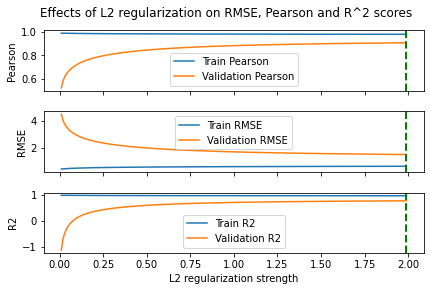

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle("Effects of L2 regularization on RMSE, Pearson and R^2 scores")

xticks = metrics["L2 regularization strength"]

ax1.plot(xticks, metrics["Train Pearson"], label="Train Pearson")
ax1.plot(xticks, metrics["Validation Pearson"], label="Validation Pearson")
ax1.axvline(best_l2, color="g", linestyle="dashed", linewidth=2)
ax1.set_ylabel("Pearson")
ax1.legend()

ax2.plot(xticks, metrics["Train RMSE"], label="Train RMSE")
ax2.plot(xticks, metrics["Validation RMSE"], label="Validation RMSE")
ax2.axvline(best_l2, color="g", linestyle="dashed", linewidth=2)
ax2.set_ylabel("RMSE")
ax2.legend()

ax3.plot(xticks, metrics["Train R2"], label="Train R2")
ax3.plot(xticks, metrics["Validation R2"], label="Validation R2")
ax3.axvline(best_l2, color="g", linestyle="dashed", linewidth=2)
ax3.set_xlabel("L2 regularization strength")
ax3.set_ylabel("R2")
ax3.legend()

plt.show()

The above plots show that when applying a stronger L2 regularization weight, the Ridge regression model performs better on the validation data, i.e. better generalization. A smaller L2 weight causes the model to overfit to the training data and generalize poorly to the validation data. No convergence is achieved on best balance between bias and variance, but the plots show that stronger L2 regularization weight improves the generalizability of the model over validation data (5-fold cross validation).

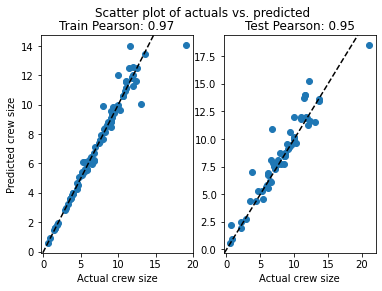

In [ ]:
# Function to draw best fit line for actuals vs. predicted
# Source: https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Scatter plot of actuals vs. predicted")
ax1.scatter(Y_train, train_preds)
ax1.set_ylabel("Predicted crew size")
ax1.set_xlabel("Actual crew size")
ax1.set_title(f"Train Pearson: {np.round(pearsonr(Y_train, train_preds)[0],2)}")
add_identity(ax1, color='black', ls='--')

ax2.scatter(Y_test, test_preds)
ax1.set_ylabel("Predicted crew size")
ax2.set_xlabel("Actual crew size")
ax2.set_title(f"Test Pearson: {np.round(pearsonr(Y_test, test_preds)[0],2)}")
add_identity(ax2, color='black', ls='--')

plt.show()

Above scatter plots show predicted vs. actuals and Pearson score for train and test set. We can see that the Ridge regression model has learnt a good set of parameters which predict well both for train and test set. A Pearson score of 1 is perfect positive linear fit. We see .97 and .95 Pearson score for train and test set respectively.

In [ ]:
print(f"Train Pearson: {pearsonr(Y_train, train_preds)[0]}")
print(f"Test Pearson: {pearsonr(Y_test, test_preds)[0]}")
print()
print(f"Train R^2: {r2_score(Y_train, train_preds)}")
print(f"Test R^2: {r2_score(Y_test, test_preds)}")
print()
print(f"Train RMSE: {rmse(Y_train, train_preds)}")
print(f"Test RMSE: {rmse(Y_test, test_preds)}")

Train Pearson: 0.9747282501552438
Test Pearson: 0.9538371244914453

Train R^2: 0.9500872833008748
Test R^2: 0.8972697396111317

Train RMSE: 0.7647542707295438
Test RMSE: 1.1392709254735993


Above is a print of Pearson, R^2 and RMSE scores for train and test set. We can see that performance is slightly worse for test set than for training set. However, still very good. We have found a good model.